# Imports


In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.models as models

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import accuracy_score
import pylab as pl
from IPython import display
from skimage import io
from skimage.transform import rescale
import datetime

# Custom functions

In [3]:
def convert(image_path, target=224):   
    image = io.imread(image_path)
    rescale_factor = target / image.shape[0],target / image.shape[1]
    scaled = rescale(image, rescale_factor, anti_aliasing=False, multichannel=True,mode='constant')[:,:,:3]
    scaled = scaled.transpose((-1, 0, 1))

    return scaled

def get_countlist(classes,directory):
    countlist = []

    for i, klasse in enumerate(classes):
        output = os.listdir("{}{}".format(directory,klasse))    
        path, dirs, files = next(os.walk("{}{}".format(directory,klasse)))
        file_count = len(files)
        print(f"Class: {i} - {file_count}\t - {classes[i]}")
        countlist.append(file_count)
    
    return countlist

In [4]:
def generate_datasets(directory,class_limit = 10,split_ratio = 0.8):
    #class_limit = 10 # max 37
    #output_limit = 20
    #split_ratio = 0.8 # training ratio

    trainlist = []
    trainclass = []
    validlist = []
    validclass = []

    for i, klasse in enumerate(classes[:class_limit+1]):
        output = os.listdir("{}/{}".format(directory,klasse))    
        output_limit = 200* split_ratio #countlist[i] * split_ratio 

        print(f"Class: {i} - {int(output_limit)}/{countlist[i]}\t - {classes[i]}")

        # Loop for training data
        for image_path in output[:int(output_limit+1)]:
            trainlist.append(convert("{}{}/{}".format(directory,klasse, image_path)))
            trainclass.append(klasse)

        # Loop for test data
        for image_path in output[int(output_limit):200]:
            validlist.append(convert("{}{}/{}".format(directory,klasse, image_path)))
            validclass.append(klasse)

    trainlist = np.asarray(trainlist)
    validlist = np.asarray(validlist)
    train_oh = pd.get_dummies(pd.DataFrame(trainclass)).values
    valid_oh = pd.get_dummies(pd.DataFrame(validclass)).values

    return trainlist, validlist, train_oh, valid_oh

In [5]:
def prepare_data(x_train,x_valid,y_train,y_valid):
    # prepare data
    inputs_train = torch.tensor(x_train).float()
    targets_train = torch.tensor(y_train).float()
    inputs_test = torch.tensor(x_valid).float()
    targets_test = torch.tensor(y_valid).float()


    device = torch.device("cuda:0" if cuda else "cpu")
    print("Using device:", device)

    inputs_train = inputs_train.to(device)
    targets_train = targets_train.to(device)
    inputs_valid = inputs_test.to(device)
    targets_valid = targets_test.to(device)
    
    return inputs_train,inputs_valid,targets_train,targets_valid


In [6]:
def training_loop(x_train,x_valid,y_train,y_valid,net,epochs=10,batch_size=64,valid_every=2):
    
        losses_train = pd.DataFrame(columns=['Epoch','Loss'])
        losses_valid = pd.DataFrame(columns=['Epoch','Loss'])
        
        for epoch in range(epochs):
            batch_loss = []

            net.train()
            for i in range(len(x_train) // batch_size):
                batch = x_train[i * batch_size: (i + 1) * batch_size] 
                labels = y_train[i * batch_size: (i + 1) * batch_size] 

                # zero the parameter gradients
                optimizer.zero_grad()

                output = net(batch)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                batch_loss.append(loss.item())


            losses_train.loc[epoch] = [epoch+1,np.mean(batch_loss)]

            if epoch%valid_every == 0:
                batch_loss = []
                net.eval()
                for i in range(len(x_valid[:100]) // BATCH_SIZE):
                    batch = x_valid[i * batch_size: (i + 1) * batch_size] 
                    labels = y_valid[i * batch_size: (i + 1) * batch_size] 


                    output = net(batch)
                    loss = criterion(output, labels)

                    batch_loss.append(loss.item())
                    accuracy = accuracy_score(labels.cpu().detach().numpy(),(output.cpu().detach().numpy() > 0.5))

                losses_valid.loc[epoch] = [epoch+1,np.mean(batch_loss)]    

            pl.figure(figsize=(15,5))
            pl.xlabel('Epochs')
            pl.ylabel('Loss')
            pl.title('Epoch #{}'.format(epoch))
            pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
            pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
            pl.legend()
            pl.show()
            print('Training loss: {:.2f}'.format(losses_train['Loss'].iloc[-1],))
            print('Validation loss:{:.2f}\tValidation accuracy: {:.2f}'.format(losses_valid['Loss'].iloc[-1],accuracy))
            display.clear_output(wait=True)



# Load dataset

In [7]:
# init functions
directory="./dataset_v2/root/train/classes/"
classes = [x[1] for x in os.walk(directory)][0]
classes.sort()

#protoype
#classes = [classes[22],classes[19] ]
classes = [classes[22],classes[19],'yellow','white','red','blue','black']


#run helper functions
countlist = get_countlist(classes,directory)
dummy = pd.get_dummies(pd.DataFrame(classes))

print("\n\n")

# get dataset
x_train, x_valid, y_train, y_valid = generate_datasets(directory,class_limit = 7,split_ratio = 0.8)  

Class: 0 - 435	 - pickup
Class: 1 - 586	 - minivan
Class: 2 - 258	 - yellow
Class: 3 - 4817	 - white
Class: 4 - 414	 - red
Class: 5 - 742	 - blue
Class: 6 - 1158	 - black



Class: 0 - 160/435	 - pickup
Class: 1 - 160/586	 - minivan
Class: 2 - 160/258	 - yellow
Class: 3 - 160/4817	 - white
Class: 4 - 160/414	 - red
Class: 5 - 160/742	 - blue
Class: 6 - 160/1158	 - black


# Define neural network
## Prepare pretrained resnet

In [8]:
#define the model
model_conv = models.resnet50(pretrained='imagenet')

# disable autograd for resnet
for param in model_conv.parameters():
    param.requires_grad = False
    
# Change fully connected layer to match paper (autograd is default on new layers)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 1024)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

## Define neural network

In [9]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  
        # input layer
        output_nodes = y_valid.shape[1]
        self.output = nn.Linear(1024,output_nodes)
       

    def forward(self, x):
        x = model_conv(x)
        x = F.relu(x)
        x = self.output(x)
        x = F.softmax(x)
        return x


net = Net()

cuda = torch.cuda.is_available()
if cuda:
    net.cuda()

# Train

In [10]:
#epochs = 30
#BATCH_SIZE= 64
#valid_every = 2
#criterion = nn.MSELoss()  # Your code here!
#optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9) # Your code here!

#x_Ttrain,x_Tvalid,y_Ttrain,y_Tvalid = prepare_data(x_train,x_valid,y_train,y_valid)


In [11]:
#now = datetime.datetime.now()
#training_loop(x_Ttrain,x_Tvalid,y_Ttrain,y_Tvalid,net,epochs=10,batch_size=64,valid_every=2)
#print(datetime.datetime.now()-now)

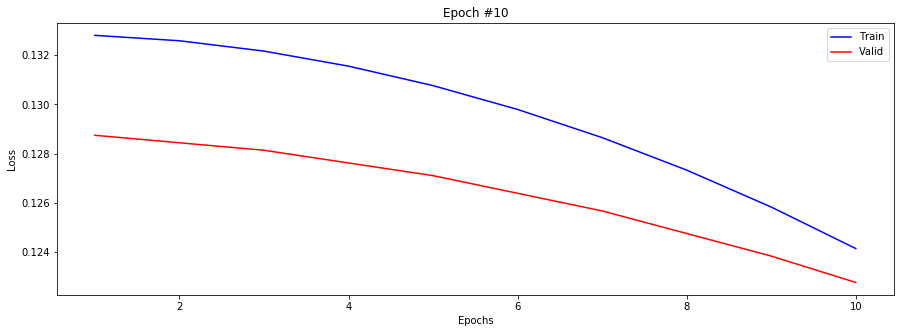

Training loss: 0.12
Validation loss:0.12	Validation accuracy: 0.00

					Training time 0:00:04.524402


In [12]:
%matplotlib inline
epochs = 10
BATCH_SIZE= 64
valid_every = 2
criterion = nn.MSELoss()  # Your code here!
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9) # Your code here!

# prepare data
inputs_train = torch.tensor(x_train).float()
targets_train = torch.tensor(y_train).float()
inputs_valid = torch.tensor(x_valid).float()
targets_valid = torch.tensor(y_valid).float()


device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

inputs_train = inputs_train.to(device)
targets_train = targets_train.to(device)
inputs_valid = inputs_valid.to(device)
targets_valid = targets_valid.to(device)

losses_train = pd.DataFrame(columns=['Epoch','Loss'])
losses_valid = pd.DataFrame(columns=['Epoch','Loss'])

accuracy = 0.01

now = datetime.datetime.now()

for epoch in range(epochs):
    batch_loss = []
   
    net.train()
    for i in range(len(inputs_train[:100]) // BATCH_SIZE):
        batch = inputs_train[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] 
        labels = targets_train[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] 
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        output = net(batch)
        #_, pred = torch.max(output.data, 1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        
       
    losses_train.loc[epoch] = [epoch+1,np.mean(batch_loss)]
    
    if epoch%valid_every == 0 or epoch == max(range(epochs)):
        batch_loss = []
        net.eval()
        for i in range(len(inputs_valid[:100]) // BATCH_SIZE):
            batch = inputs_valid[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] 
            labels = targets_valid[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] 


            output = net(batch)
            loss = criterion(output, labels)

            batch_loss.append(loss.item())
            accuracy = accuracy_score(labels.cpu().detach().numpy(),(output.cpu().detach().numpy() > 0.5))
        
        losses_valid.loc[epoch] = [epoch+1,np.mean(batch_loss)]    
    
    pl.figure(figsize=(15,5))
    pl.xlabel('Epochs')
    pl.ylabel('Loss')
    pl.title('Epoch #{}'.format(epoch+1))
    pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
    pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
    pl.legend()
    pl.show()
    print('Training loss: {:.2f}'.format(losses_train['Loss'].iloc[-1],))
    print('Validation loss:{:.2f}\tValidation accuracy: {:.2f}'.format(losses_valid['Loss'].iloc[-1],accuracy))
    display.clear_output(wait=True)
    

    
pl.figure(figsize=(15,5))
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.title('Epoch #{}'.format(epoch+1))
pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
pl.legend()
pl.show()

print('Training loss: {:.2f}'.format(losses_train['Loss'].iloc[-1],))
print('Validation loss:{:.2f}\tValidation accuracy: {:.2f}'.format(losses_valid['Loss'].iloc[-1],accuracy))

print("\n\t\t\t\t\tTraining time {}".format(datetime.datetime.now()-now))